# Differentiable Physics III: Finite Difference Method

We define a regular grid of cells, where each cell has a size of $\Delta x \times \Delta y$. On this grid we define a scalar field $f$ and a vector field $u$.

## Calculus Preliminaries

Common operators for scalar $f$ and vector fields $v$ used in this context:

| Operator | Symbol | Description | Intuition |
| --- | --- | --- | --- |
| Gradient | $\nabla$ | $\nabla f = \begin{bmatrix} \frac{\partial f}{\partial x} \\ \frac{\partial f}{\partial y} \end{bmatrix}$ | Slope of a mountain |
| Divergence | $\nabla \cdot$ | $\nabla \cdot \vec{u} = \frac{\partial u_x}{\partial x} + \frac{\partial u_y}{\partial y}$ | Inflow minus outflow |
| Laplacian | $\nabla^2$ | $\nabla^2 f = \Delta f = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2}$ | Linear slope has zero laplacian, peak has high negative |
| Curl | $\nabla \times$ | $\nabla \times \vec{u} = \frac{\partial u_y}{\partial x} - \frac{\partial u_x}{\partial y}$ | Rotation of a vector field |
| Jacobian | $J$ | $J v = \begin{bmatrix} \frac{\partial u_x }{\partial x} & \frac{\partial u_x }{\partial y} \\ \frac{\partial u_y }{\partial x} & \frac{\partial u_y }{\partial y} \end{bmatrix}$ | Change of variables |
| Hessian | $H$ | $H f = \begin{bmatrix} \frac{\partial^2 f}{\partial x^2} & \frac{\partial^2 f}{\partial x \partial y} \\ \frac{\partial^2 f}{\partial y \partial x} & \frac{\partial^2 f}{\partial y^2} \end{bmatrix}$ | Change of variables |


## Finite Difference Method

In a discrete setting we can approximate common operations as follows:

| Operation | Formula | Numerical Approximation |
| --- | --- | --- |
| Forward Difference | $\frac{\partial u}{\partial x}$ | $\frac{u_{i+i, j} - u_{i,j}}{\Delta x}$ |
| Backward Difference | $\frac{\partial u}{\partial x}$ | $\frac{u_{i, j} - u_{i-1,j}}{\Delta x}$ |
| Central Difference | $\frac{\partial u}{\partial x}$ | $\frac{u_{i+1, j} - u_{i-1,j}}{2 \Delta x}$ |
| Second Order Central | $\frac{\partial^2 u}{\partial x^2}$ | $\frac{u_{i+1, j} - 2 u_{i,j} + u_{i-1,j}}{\Delta x^2}$ |
| Second Order Forward | $\frac{\partial^2 u}{\partial x^2}$ | $\frac{u_{i+2, j} - 2 u_{i+1,j} + u_{i,j}}{\Delta x^2}$ |
| Second Order Backward | $\frac{\partial^2 u}{\partial x^2}$ | $\frac{u_{i, j} - 2 u_{i-1,j} + u_{i-2,j}}{\Delta x^2}$ |
| Gradient | $\nabla f$ | $\begin{bmatrix} \frac{f_{i+1, j} - f_{i-1,j}}{2 \Delta x} \\ \frac{f_{i, j+1} - f_{i,j-1}}{2 \Delta y} \end{bmatrix}$ |


Text(0.5, 1.0, 'Vector field')

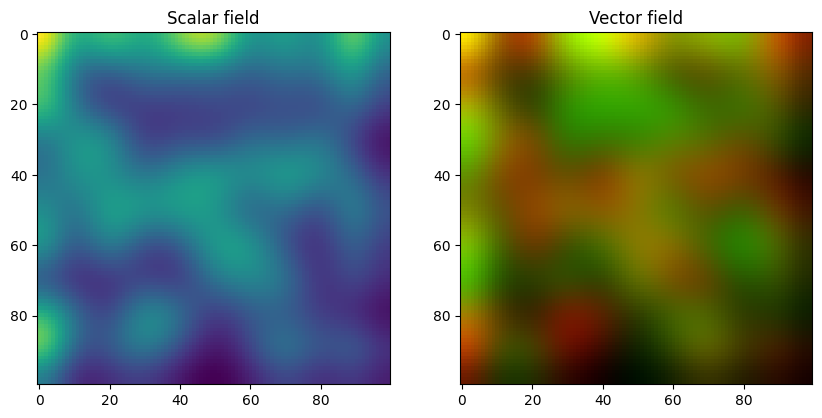

In [21]:
import numpy as np
import matplotlib.pyplot as plt
# import convolve ndimage
from scipy.ndimage import convolve

def coherent_noise(grid_size_sparse : int, grid_size_dense : int, seed=None) -> np.ndarray:
    # Sparse and dense random sampling
    grid_size_sparse = 10
    values_sparse = np.random.random((grid_size_sparse, grid_size_sparse))

    grid_size_dense = 100
    stride = grid_size_dense // grid_size_sparse
    values_dense = np.zeros((grid_size_dense, grid_size_dense))
    values_dense[::stride, ::stride] = values_sparse

    # Blur kernel
    kernel = np.array([[1, 2, 1],[2, 4, 2],[1, 2, 1]]) / 16

    for i in range(100):
        values_dense = convolve(values_dense, kernel)

    max = np.max(values_dense)
    min = np.min(values_dense)

    values_dense = (values_dense - min) / (max - min)

    return values_dense

noise_x = coherent_noise(10, 100)
noise_y = coherent_noise(10, 100)

noise_xy = np.stack([noise_x, noise_y], axis=-1)
noise_xyz = np.stack([noise_x, noise_y, np.zeros_like(noise_x)], axis=-1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(noise_x)
axs[0].set_title("Scalar field")
axs[1].imshow(noise_xyz)
axs[1].set_title("Vector field")


Now we can apply the listed operators to the fields.

In [ ]:
def gradient(field : np.ndarray) -> np.ndarray:
    

## Finite Difference Method and Discretization

We can approximate the derivatives of a function $f$ with respect to $x$ and $y$ as using the **forward difference** method:

$$\frac{\partial f}{\partial x} \approx \frac{f(x + \Delta x, y) - f(x, y)}{\Delta x}$$

When we use a uniform grid:

$$\frac{\partial f}{\partial x} \approx \frac{f_{i+1, j} - f_{i, j}}{\Delta x}$$

Analagously we can approximate the **backward difference** as:

$$\frac{\partial f}{\partial x} \approx \frac{f_{i, j} - f_{i-1, j}}{\Delta x}$$

And the **central difference** as:

$$\frac{\partial f}{\partial x} \approx \frac{f_{i+1, j} - f_{i-1, j}}{2 \Delta x}$$

We can compose these approximations to get the following approximations for the second derivatives. The **second order central difference**:

$$\frac{\partial^2 f}{\partial x^2} \approx \frac{f_{i+1, j} - 2 f_{i, j} + f_{i-1, j}}{\Delta x^2}$$
